## Лабораторная работа №1. Логистическая регрессия в качестве нейронной сети

#### Данные: 
В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

#### Ход выполнения:
###### Задание 1.
Загрузите данные и отобразите на экране несколько из изображений с помощью языка Python.

Скачаем необходимые данные по ссылке:
- https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz (большой набор данных) 
- https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz (маленький набор данных)

In [1]:
from __future__ import print_function
import os
import sys
from six.moves.urllib.request import urlretrieve

url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()
        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename)
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Not found or already exist on the file system.')
    return filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Found and verified notMNIST_large.tar.gz
Found and verified notMNIST_small.tar.gz


Были скачены файлы notMNIST_large.tar.gz и notMNIST_small.tar.gz.  
Распакуем содержимое .tar.gz файлов.  

In [2]:
import tarfile
import os

num_classes = 10
data_root = '.'

def maybe_extract(filename):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]
    if os.path.isdir(root):
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
    data_folders = [
        os.path.join(root, folder) for folder in sorted(os.listdir(root))
        if os.path.isdir(os.path.join(root, folder))]
    if len(data_folders) != num_classes:
        raise Exception('Expected %d folders, one per class. Found %d instead.' % (num_classes, len(data_folders)))
    print(data_folders)
    return data_folders

train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

notMNIST_large already present - Skipping extraction of notMNIST_large.tar.gz.
['notMNIST_large\\A', 'notMNIST_large\\B', 'notMNIST_large\\C', 'notMNIST_large\\D', 'notMNIST_large\\E', 'notMNIST_large\\F', 'notMNIST_large\\G', 'notMNIST_large\\H', 'notMNIST_large\\I', 'notMNIST_large\\J']
notMNIST_small already present - Skipping extraction of notMNIST_small.tar.gz.
['notMNIST_small\\A', 'notMNIST_small\\B', 'notMNIST_small\\C', 'notMNIST_small\\D', 'notMNIST_small\\E', 'notMNIST_small\\F', 'notMNIST_small\\G', 'notMNIST_small\\H', 'notMNIST_small\\I', 'notMNIST_small\\J']


Отобразим несколько изображений из набора данных:

In [3]:
import random
from IPython.display import display, Image

%matplotlib inline

In [4]:
def display_samples(data_folders, number_of_samples):
  for folder in data_folders:
    print('From folder %s:' % folder)
    image_files = os.listdir(folder)
    image_sample = random.sample(image_files, number_of_samples)
    for image in image_sample:
      image_file = os.path.join(folder, image)
      image_to_display = Image(filename=image_file)
      display(image_to_display)

In [5]:
display_samples(train_folders, 1)

From folder notMNIST_large\A:


From folder notMNIST_large\B:


From folder notMNIST_large\C:


From folder notMNIST_large\D:


From folder notMNIST_large\E:


From folder notMNIST_large\F:


From folder notMNIST_large\G:


From folder notMNIST_large\H:


From folder notMNIST_large\I:


From folder notMNIST_large\J:


In [6]:
display_samples(test_folders, 1)

From folder notMNIST_small\A:


From folder notMNIST_small\B:


From folder notMNIST_small\C:


From folder notMNIST_small\D:


From folder notMNIST_small\E:


From folder notMNIST_small\F:


From folder notMNIST_small\G:


From folder notMNIST_small\H:


From folder notMNIST_small\I:


From folder notMNIST_small\J:


###### Задание 2.
Проверьте, что классы являются сбалансированными, т.е. количество изображений, принадлежащих каждому из классов, примерно одинаково (В данной задаче 10 классов).


Загрузим данные в более управляемый формат. Поскольку мы не сможем разместить все данные в памяти компьютера, загрузим каждый класс в отдельный набор данных, сохраним их на диске и будем вызывать их независимо. Затем объединим данные в один набор с управляемым размером.  
  
Преобразуем набор данных в трехмерный массив (image index, x, y) значений с плавающей запятой, нормализованный так, чтобы иметь среднее нулевое среднее значение и стандартное отклонение ~ 0,5, чтобы упростить обучение в будущем.

Пропустим не читаемые изображения.

In [7]:
import numpy as np
import imageio
from six.moves import cPickle as pickle

image_size = 28  # Image width and height.
pixel_depth = 255.0  # RGB pixels.

def load_letter(folder, min_num_images):
    image_files = os.listdir(folder)
    dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
    print(folder)
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        try:
            image_data = (imageio.imread(image_file).astype(float) - pixel_depth / 2) / pixel_depth
            if image_data.shape != (image_size, image_size):
                raise Exception('Unexpected image shape: %s' % str(image_data.shape))
            dataset[num_images, :, :] = image_data
            num_images = num_images + 1
        except (IOError, ValueError) as e:
            print('Could not read:', image_file, ':', e, '- skipping.')

    dataset = dataset[0:num_images, :, :]
    if num_images < min_num_images:
        raise Exception('Many fewer images than expected: %d < %d' % (num_images, min_num_images))

    print('Full dataset tensor:', dataset.shape)
    print('Mean:', np.mean(dataset))
    print('Standard deviation:', np.std(dataset))
    return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
    dataset_names = []
    for folder in data_folders:
        set_filename = folder + '.pickle'
        dataset_names.append(set_filename)
        if os.path.exists(set_filename) and not force:
            print('%s already present - Skipping pickling.' % set_filename)
        else:
            print('Pickling %s.' % set_filename)
            dataset = load_letter(folder, min_num_images_per_class)
            try:
                with open(set_filename, 'wb') as f:
                    pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
            except Exception as e:
                print('Unable to save data to', set_filename, ':', e)

    return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

notMNIST_large\A.pickle already present - Skipping pickling.
notMNIST_large\B.pickle already present - Skipping pickling.
notMNIST_large\C.pickle already present - Skipping pickling.
notMNIST_large\D.pickle already present - Skipping pickling.
notMNIST_large\E.pickle already present - Skipping pickling.
notMNIST_large\F.pickle already present - Skipping pickling.
notMNIST_large\G.pickle already present - Skipping pickling.
notMNIST_large\H.pickle already present - Skipping pickling.
notMNIST_large\I.pickle already present - Skipping pickling.
notMNIST_large\J.pickle already present - Skipping pickling.
notMNIST_small\A.pickle already present - Skipping pickling.
notMNIST_small\B.pickle already present - Skipping pickling.
notMNIST_small\C.pickle already present - Skipping pickling.
notMNIST_small\D.pickle already present - Skipping pickling.
notMNIST_small\E.pickle already present - Skipping pickling.
notMNIST_small\F.pickle already present - Skipping pickling.
notMNIST_small\G.pickle 

Проверим, что данные все еще выглядят хорошо. Отобразим образцы меток и изображений из ndarray.

In [8]:
import matplotlib.pyplot as plt

def disp_8_img(imgs, titles):
  for i, img in enumerate(imgs):
    plt.subplot(2, 4, i+1)
    plt.title(titles[i])
    plt.axis('off')
    plt.imshow(img)

def disp_sample_pickles(data_folders):
  folder = random.sample(data_folders, 1)
  pickle_filename = ''.join(folder) + '.pickle'
  try:
    with open(pickle_filename, 'rb') as f:
      dataset = pickle.load(f)
  except Exception as e:
    print('Unable to read data from', pickle_filename, ':', e)
    return
  plt.suptitle(''.join(folder)[-1])
  for i, img in enumerate(random.sample(list(dataset), 8)):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    plt.imshow(img)

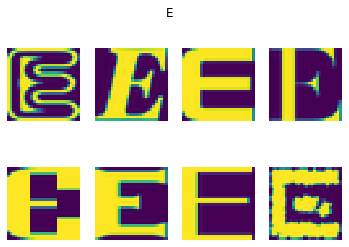

In [9]:
disp_sample_pickles(train_folders)

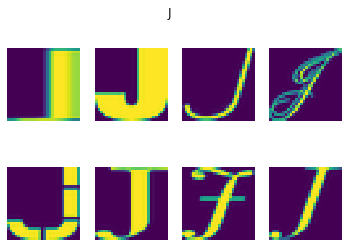

In [10]:
disp_sample_pickles(test_folders)

Данные сбалансированы по классам, если в классах примерно одинаковое количество элементов. Проверим количество изображений по классам.

In [11]:
def disp_number_images(data_folders):
  for folder in data_folders:
    pickle_filename = ''.join(folder) + '.pickle'
    try:
      with open(pickle_filename, 'rb') as f:
        dataset = pickle.load(f)
    except Exception as e:
      print('Unable to read data from', pickle_filename, ':', e)
      return
    print('Number of images in ', folder, ' : ', len(dataset))
    
disp_number_images(train_folders)
disp_number_images(test_folders)

Number of images in  notMNIST_large\A  :  52909
Number of images in  notMNIST_large\B  :  52911
Number of images in  notMNIST_large\C  :  52912
Number of images in  notMNIST_large\D  :  52911
Number of images in  notMNIST_large\E  :  52912
Number of images in  notMNIST_large\F  :  52912
Number of images in  notMNIST_large\G  :  52912
Number of images in  notMNIST_large\H  :  52912
Number of images in  notMNIST_large\I  :  52912
Number of images in  notMNIST_large\J  :  52911
Number of images in  notMNIST_small\A  :  1872
Number of images in  notMNIST_small\B  :  1873
Number of images in  notMNIST_small\C  :  1873
Number of images in  notMNIST_small\D  :  1873
Number of images in  notMNIST_small\E  :  1873
Number of images in  notMNIST_small\F  :  1872
Number of images in  notMNIST_small\G  :  1872
Number of images in  notMNIST_small\H  :  1872
Number of images in  notMNIST_small\I  :  1872
Number of images in  notMNIST_small\J  :  1872


###### Задание 3.
Разделите данные на три подвыборки: обучающую (200 тыс. изображений), валидационную (10 тыс. изображений) и контрольную (тестовую) (19 тыс. изображений).


Есть незначительное количество пробелов, поэтому классы хорошо сбалансированы. Объединим и обрежем данные обучения и разместим в памяти, настроим train_size = 200000, valid_size = 10000, test_size = 18000. Метки будут храниться в отдельном массиве целых чисел от 0 до 9. Создадим валидационный набор данных для настройки гиперпараметров. Используем показатели 

In [12]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
                       
train_size = 200000
valid_size = 10000
test_size = 18000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (18000, 28, 28) (18000,)


###### Задание 4.
Проверьте, что данные из обучающей выборки не пересекаются с данными из валидационной и контрольной выборок. Другими словами, избавьтесь от дубликатов в обучающей выборке.


Подготовим дата сет для дальнейшей работы. Для этого рандомизируем данные, чтобы ярлыки были хорошо перетасованы для соответствия обучающей и тестовой выборки.

In [13]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

Чтобы быть уверенным, что данные все еще в порядке после слияния и рандомизации, выберем один элемент и выведем изображение рядом с меткой: 0 = A, 1 = B, 2 = C, 3 = D, 4 = E, 5 = F, 6 = G, 7 = H, 8 = I, 9 = J.

In [43]:
pretty_labels = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J'}

def disp_sample_dataset(dataset, labels, title=None):
    fig = plt.figure()
    if title: fig.suptitle(title, fontsize=16, fontweight='bold')
    items = random.sample(range(len(labels)), 8)
    for i, item in enumerate(items):
        plt.subplot(2, 4, i + 1)
        plt.axis('off')
        plt.title(chr(ord('A') + labels[item]))
        plt.imshow(dataset[item])
    plt.show()

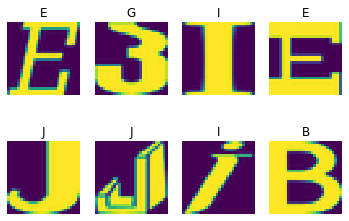

In [44]:
disp_sample_dataset(train_dataset, train_labels)

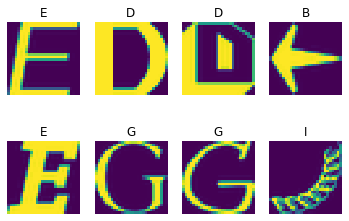

In [45]:
disp_sample_dataset(valid_dataset, valid_labels)

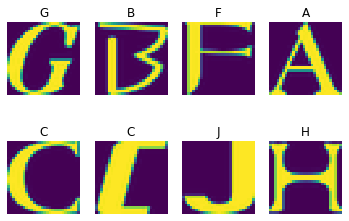

In [46]:
disp_sample_dataset(test_dataset, test_labels)

Сохраним данные для последующего повторного использования:

In [18]:
pickle_file = 'notMNIST.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [19]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 715920515


Для проверки данных из обучающей выборки на наличие пересекающихся значений с данными из валидационной и контрольной выборок используем хеш-функцию. Чтобы найти точные дубликаты, хеш-функции, используемые для криптографии, будут работать достаточно эффективно. Для того, чтобы избавиться от дибликатов в наборах данных удалим значения с одинаковым хешем и возвратим чистый набор данных.

In [20]:
import hashlib

def sanetize(dataset_1, dataset_2, labels_1):
  dataset_hash_1 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_1])
  dataset_hash_2 = np.array([hashlib.sha256(img).hexdigest() for img in dataset_2])
  overlap = []
  for i, hash1 in enumerate(dataset_hash_1):
    duplicates = np.where(dataset_hash_2 == hash1)
    if len(duplicates[0]):
      overlap.append(i) 
  return np.delete(dataset_1, overlap, 0), np.delete(labels_1, overlap, None)

In [21]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset[:200], train_dataset, test_labels[:200])
print('Overlapping images removed: ', len(test_dataset[:200]) - len(test_dataset_sanit))

Wall time: 2.76 s
Overlapping images removed:  22


In [22]:
%time test_dataset_sanit, test_labels_sanit = sanetize(test_dataset, train_dataset, test_labels)
print('Overlapping images removed: ', len(test_dataset) - len(test_dataset_sanit))

Wall time: 1min 9s
Overlapping images removed:  2317


In [23]:
%time valid_dataset_sanit, valid_labels_sanit = sanetize(valid_dataset, train_dataset, valid_labels)
print('Overlapping images removed: ', len(valid_dataset) - len(valid_dataset_sanit))

Wall time: 38.9 s
Overlapping images removed:  1063


In [24]:
pickle_file_sanit = 'notMNIST_sanit.pickle'

try:
  f = open(pickle_file_sanit, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset_sanit,
    'valid_labels': valid_labels_sanit,
    'test_dataset': test_dataset_sanit,
    'test_labels': test_labels_sanit,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [25]:
statinfo = os.stat(pickle_file_sanit)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 705307306


###### Задание 5.
Постройте простейший классификатор (например, с помощью логистической регрессии). Постройте график зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000). Для построения классификатора можете использовать библиотеку SkLearn (http://scikit-learn.org).
  
Построим логистическую регрессию.

Accuracy: 0.4852222222222222 when sample_size= 50


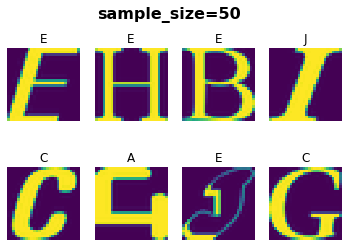

Accuracy: 0.6407777777777778 when sample_size= 100


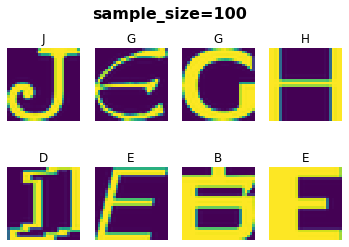

Accuracy: 0.8385555555555556 when sample_size= 1000


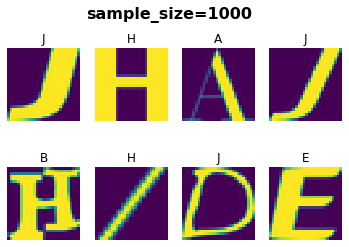

Accuracy: 0.8873888888888889 when sample_size= 50000


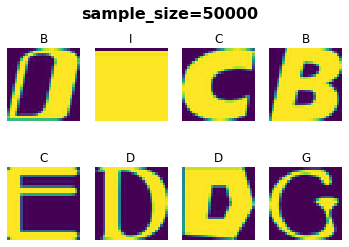

In [68]:
from sklearn.linear_model import LogisticRegression

def train_and_predict(sample_size):
    regr = LogisticRegression(max_iter=1000)
    X_train = train_dataset[:sample_size].reshape(sample_size, 784)
    y_train = train_labels[:sample_size]
    regr.fit(X_train, y_train)

    X_test = test_dataset.reshape(test_dataset.shape[0], 28 * 28)
    y_test = test_labels

    pred_labels = regr.predict(X_test)
    acc = regr.score(X_test, y_test)
    print('Accuracy:', acc, 'when sample_size =', sample_size)
    disp_sample_dataset(test_dataset, pred_labels, 'sample_size =' + str(sample_size))
    return acc

sample_sizes = [50, 100, 1000, 50000]
accuracy = []

for sample_size in sample_sizes:
    accuracy.append(train_and_predict(sample_size))
    

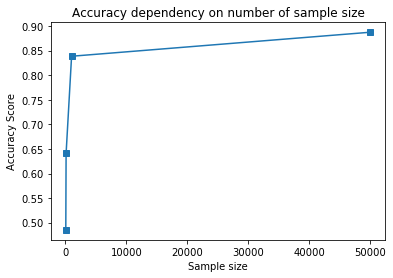

In [69]:
x = np.array(sample_sizes)
y = np.array(accuracy)

plt.plot(x, y, 's', linestyle='-')
plt.title("Accuracy dependency on number of sample size")
plt.xlabel("Sample size")
plt.ylabel("Accuracy Score")
plt.grid(False)
plt.show()